In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
from VRNet import VRNet
from VRNet import VRDataLoader

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
rgb mean:  tensor([0.0022, 0.0022, 0.0021])
rgb std:  tensor([0.0008, 0.0009, 0.0010])
depth mean:  tensor([0.0036])
depth std:  tensor([0.0001])
states mean:  tensor([-0.0063, -0.0014,  0.0073,  0.0049,  0.0160,  0.0379,  1.0000],
       device='cuda:0')
states std:  tensor([0.0443, 0.0074, 0.0682, 0.1280, 0.0718, 0.2444, 0.0000],
       device='cuda:0')


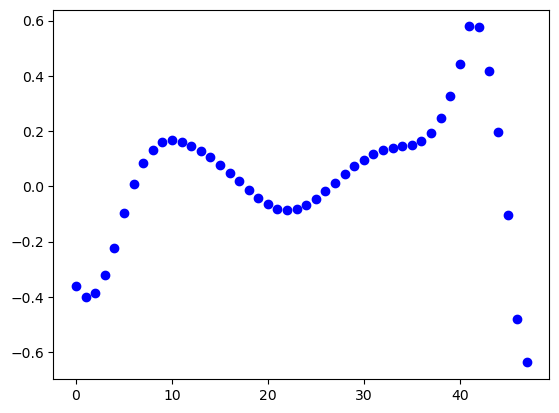

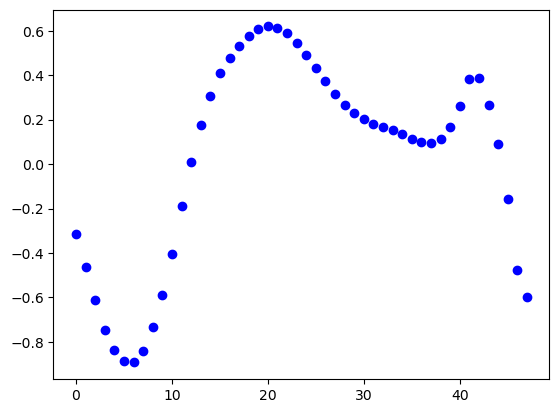

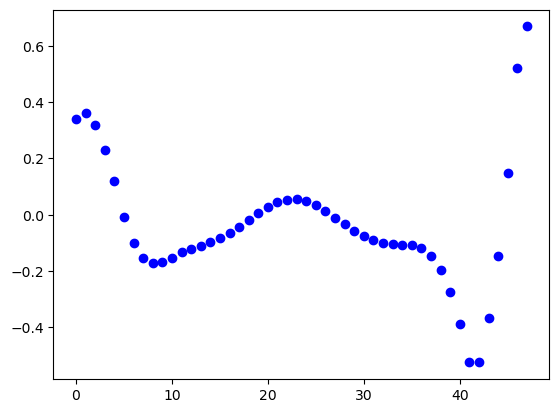

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


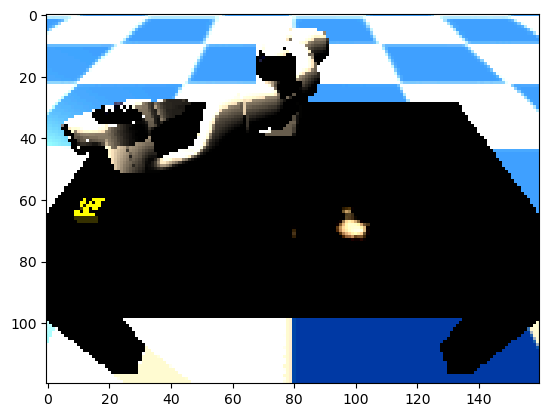

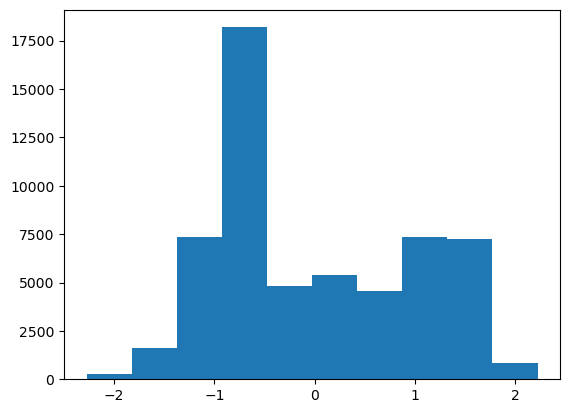

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


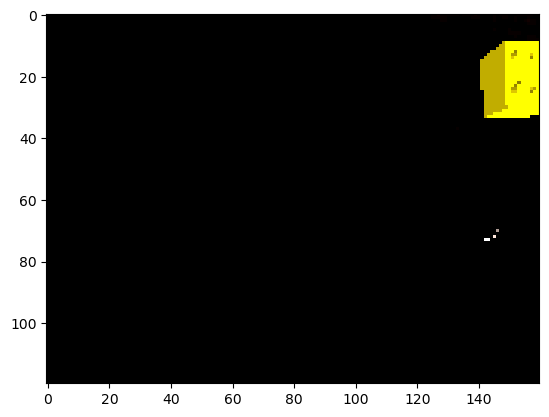

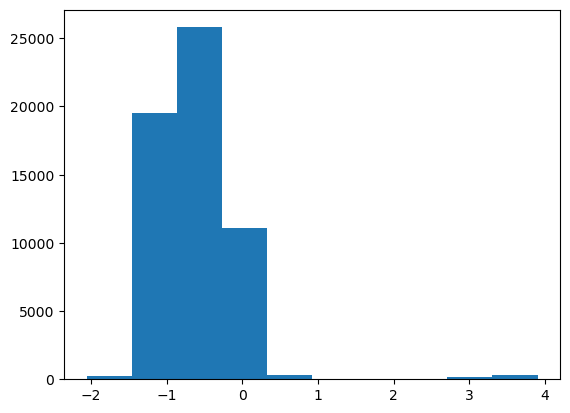

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


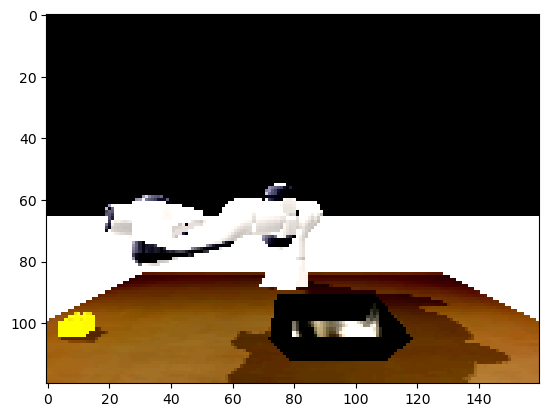

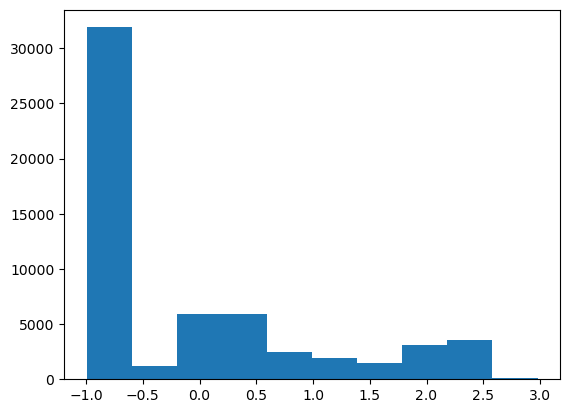

In [3]:
dataloader = VRDataLoader('data_all_cams', 1, 2, batch_size=128)

states = dataloader.states
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#set outliers to 0 (where |x| > 1)
for i in range(len(states)):
    if abs(states[i][0]) > 1:
        #interpolate between two adjacent states
        #if either value adjacent is out of bounds, use the other
        if i == 0:
            states[i][0] = states[i+1][0]
        elif i == states.shape[0] - 1:
            states[i][0] = states[i-1][0]
        else:
            states[i][0] = (states[i-1][0] + states[i+1][0]) / 2
    if abs(states[i][1]) > 1:
        if i == 0:
            states[i][1] = states[i+1][1]
        elif i == states.shape[0] - 1:
            states[i][1] = states[i-1][1]
        else:
            states[i][1] = (states[i-1][1] + states[i+1][1]) / 2
    if abs(states[i][2]) > 1:
        if i == 0:
            states[i][2] = states[i+1][2]
        elif i == states.shape[0] - 1:
            states[i][2] = states[i-1][2]
        else:
            states[i][2] = (states[i-1][2] + states[i+1][2]) / 2

#apply a gaussian filter to smooth out the data
gaussian_filter = np.array([1, 2, 3, 4, 5, 4, 3, 2, 1])
gaussian_filter = gaussian_filter / np.sum(gaussian_filter)

states = states.cpu().numpy()
for i in range(6):
    states[:, i] = np.convolve(states[:, i], gaussian_filter, mode='same')
states = torch.tensor(states).to('cuda')

#plot x velocities
plt.plot([state[0].cpu() for state in states][0:500], 'bo')
plt.show()

#plot y velocities
plt.plot([state[1].cpu() for state in states][0:500], 'bo')
plt.show()

#plot z velocities
plt.plot([state[2].cpu() for state in states][0:500], 'bo')
plt.show()

#display Top image
plt.imshow(dataloader.rgbTop_images[0].permute(1,2,0))
plt.show()
#display histogram of Top image
plt.hist(dataloader.rgbTop_images[0].permute(1,2,0).flatten().cpu().numpy())
plt.show()
#display Top image
plt.imshow(dataloader.rgbEff_images[0].permute(1,2,0))
plt.show()
#display histogram of Top image
plt.hist(dataloader.rgbEff_images[0].permute(1,2,0).flatten().cpu().numpy())
plt.show()
#display Top image
plt.imshow(dataloader.rgbSide_images[0].permute(1,2,0))
plt.show()
#display histogram of Top image
plt.hist(dataloader.rgbSide_images[0].permute(1,2,0).flatten().cpu().numpy())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


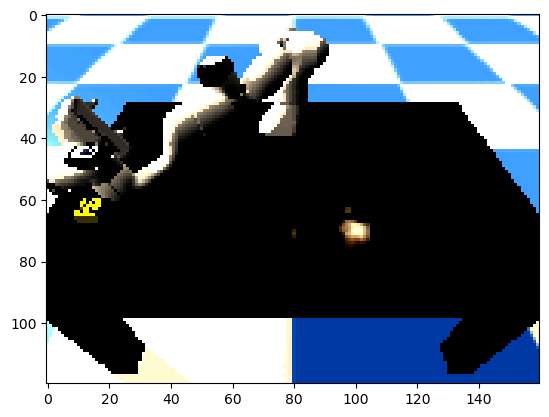

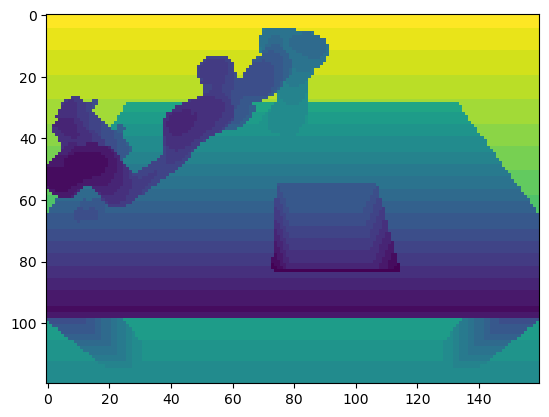

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


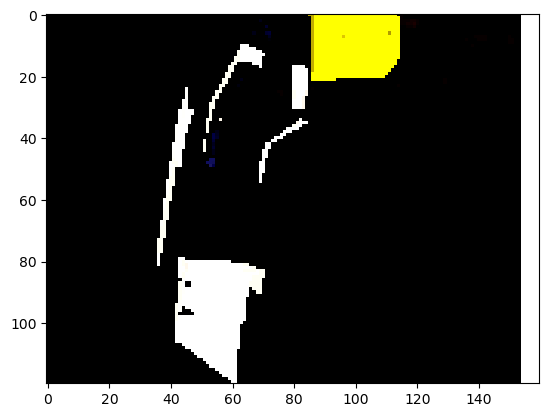

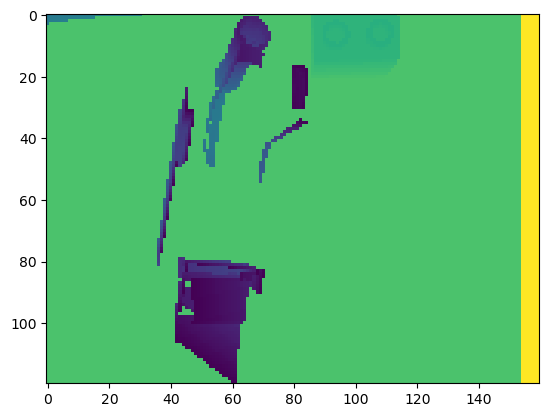

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


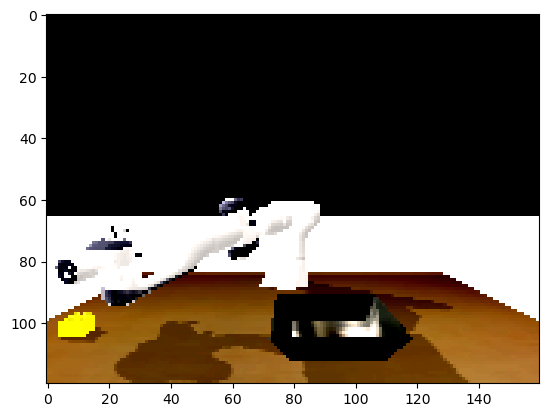

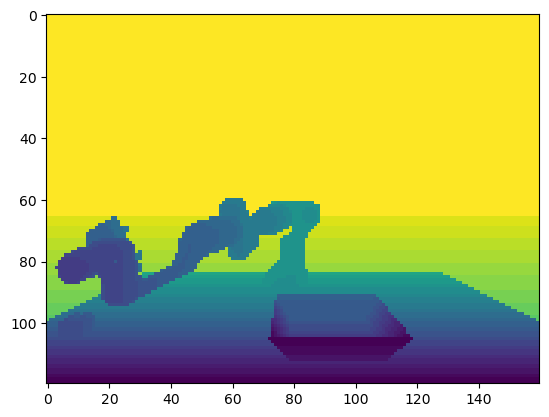

tensor([ 0.0865,  0.2497, -0.0618, -0.1772,  0.2511, -0.1307,  1.0000],
       device='cuda:0')
0


In [4]:
#show a random img from the dataset
import matplotlib.pyplot as plt
import random

idx = 0 #random.randint(0, len(dataloader))
data = dataloader[idx]
rgbTop_img, depthTop_img, rgbEff_img, depthEff_img, rgbSide_img, depthSide_img, state = data[0][0], data[1][0], data[2][0], data[3][0], data[4][0], data[5][0], data[6][0]

plt.imshow(rgbTop_img.permute(1, 2, 0))
plt.show()

plt.imshow(depthTop_img.permute(1, 2, 0))
plt.show()

plt.imshow(rgbEff_img.permute(1, 2, 0))
plt.show()

plt.imshow(depthEff_img.permute(1, 2, 0))
plt.show()

plt.imshow(rgbSide_img.permute(1, 2, 0))
plt.show()

plt.imshow(depthSide_img.permute(1, 2, 0))
plt.show()

print(state)

print(len(dataloader))

0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


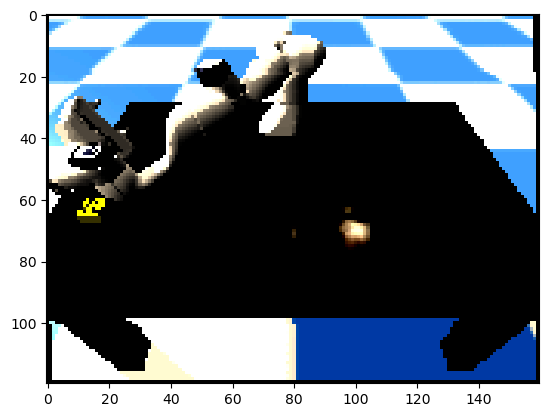

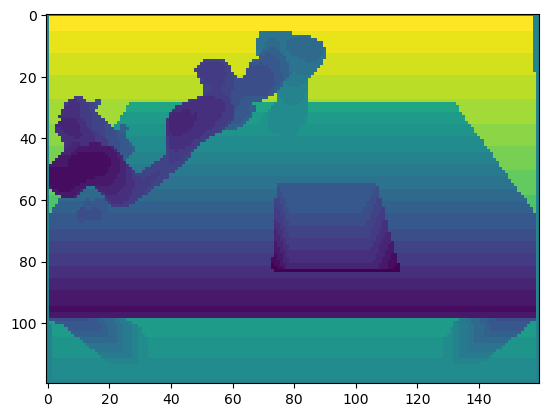

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


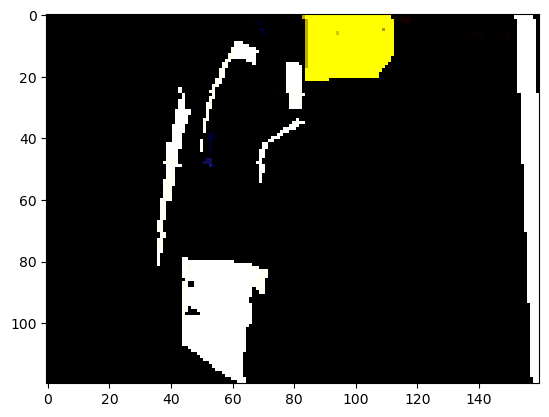

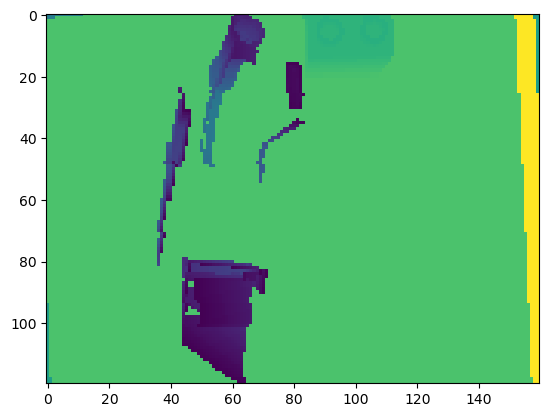

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


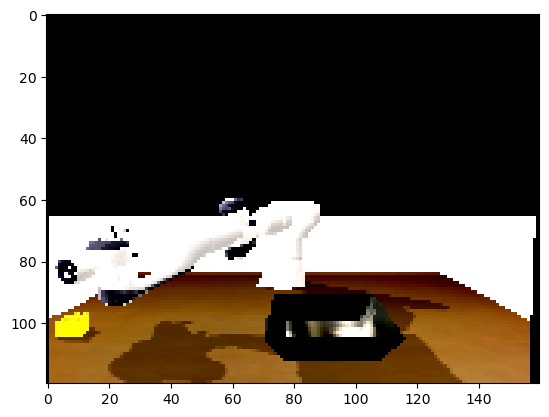

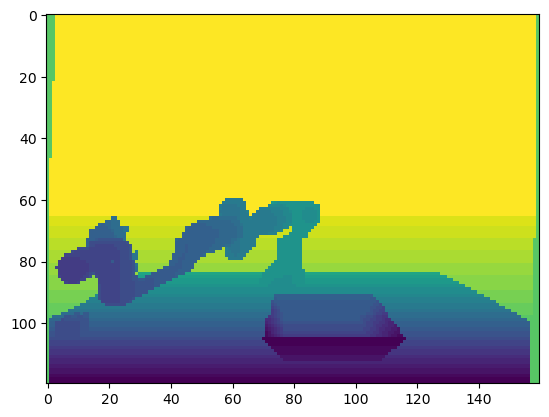

In [5]:
#add data augmentation
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(0, shear=3),
    torchvision.transforms.RandomAffine(0, scale=(0.98, 1.02)),
    # torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.05),
    # torchvision.transforms.RandomApply([torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.5),
])

def applyTransforms(rgbTop_img, depthTop_img, rgbEff_img, depthEff_img, rgbSide_img, depthSide_img):
    rngstate = torch.random.get_rng_state()
    rgbTop_img = transform(rgbTop_img)
    rgbEff_img = transform(rgbEff_img)
    rgbSide_img = transform(rgbSide_img)
    torch.random.set_rng_state(rngstate)
    depthTop_img = transform(depthTop_img)
    depthEff_img = transform(depthEff_img)
    depthSide_img = transform(depthSide_img)
    return rgbTop_img, depthTop_img, rgbEff_img, depthEff_img, rgbSide_img, depthSide_img

idx = random.randint(0, len(dataloader))
print(idx)
data = dataloader[idx]
rgbTop_img, depthTop_img, rgbEff_img, depthEff_img, rgbSide_img, depthSide_img, state = data[0][0], data[1][0], data[2][0], data[3][0], data[4][0], data[5][0], data[6][0]

rgbTop_img, depthTop_img, rgbEff_img, depthEff_img, rgbSide_img, depthSide_img = applyTransforms(rgbTop_img, depthTop_img, rgbEff_img, depthEff_img, rgbSide_img, depthSide_img)

#apply same transform to both depth and rgb image
plt.imshow(rgbTop_img.permute(1, 2, 0))
plt.show()

plt.imshow(depthTop_img.permute(1, 2, 0))
plt.show()

plt.imshow(rgbEff_img.permute(1, 2, 0))
plt.show()

plt.imshow(depthEff_img.permute(1, 2, 0))
plt.show()

plt.imshow(rgbSide_img.permute(1, 2, 0))
plt.show()

plt.imshow(depthSide_img.permute(1, 2, 0))
plt.show()


In [6]:
class LcLoss(nn.Module):
    def __init__(self):
        super(LcLoss, self).__init__()

    def forward(self, pred, target):
        loss = torch.zeros(pred.shape[0])
        for i in range(pred.shape[0]):
            p = pred[i]
            t = target[i]
            loss[i] = torch.arccos(torch.dot(t, p) / (torch.norm(t) * torch.norm(p)))
        
        return torch.sum(loss)

class LgLoss(nn.Module):
    def __init__(self):
        super(LgLoss, self).__init__()

    def forward(self, pred, target):
        loss = torch.zeros(pred.shape[0])
        for i in range(pred.shape[0]):
            p = pred[i]
            t = target[i]
            loss[i] = p * torch.log(t) - (1 - p) * torch.log(1 - t)
        return torch.sum(loss)

In [7]:
loss_weights = [1, 0.01, 0.005, 0.0001]

def train(model, data_loader, num_epochs, learning_rate, device):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    L1_loss = nn.L1Loss()
    L2_loss = nn.MSELoss()
    L_c_loss = LcLoss()
    L_g_loss = nn.CrossEntropyLoss()
    print(len(data_loader))
    for epoch in range(num_epochs):
        for i in range(len(data_loader)+1):
            rgbTop_img, depthTop_img, rgbEff_img, depthEff_img, rgbSide_img, depthSide_img, state = data_loader[i]
            
            # rgb_img = rgb_img
            # depth_img = depth_img

            #get rgb and depth images
            rgbTop_img = rgbTop_img.to(device).float()
            depthTop_img = depthTop_img.to(device).float()
            rgbEff_img = rgbEff_img.to(device).float()
            depthEff_img = depthEff_img.to(device).float()
            rgbSide_img = rgbSide_img.to(device).float()
            depthSide_img = depthSide_img.to(device).float()
            
            #apply data augmentation
            # rgb_img, depth_img = applyTransforms(rgb_img, depth_img)
            
            #add batch dimension
            state = state.to(device).float()

            optimizer.zero_grad()
            output = model(rgbTop_img, depthTop_img, rgbEff_img, depthEff_img, rgbSide_img, depthSide_img)
            
            #calculate combined loss
            # loss = L1_loss(output[0:3], state[0:3]) * loss_weights[0]
            #combine 0:3 and 6
            important_output = torch.cat((output[:, 0:3], output[:, 6].unsqueeze(1)), dim=1)
            important_state = torch.cat((state[:, 0:3], state[:, 6].unsqueeze(1)), dim=1)
            
            loss = L1_loss(important_output, important_state) # * loss_weights[1]
            # loss += L_c_loss(output[:, 0:6], state[:, 0:6]) * loss_weights[2]
            # loss += L_g_loss(output[:, 6], state[:, 6]) * loss_weights[3]
            

            loss.backward()
            optimizer.step()

            print(f'Epoch: {epoch}, Iteration: {i}, Loss: {loss.item()}')
    

In [8]:
#train the model
# device = torch.device('cuda')
model = VRNet().to(device)

c:\Users\RUSHI\anaconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\RUSHI\anaconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
train(model, dataloader, 500, 0.0005, device)

0
Epoch: 0, Iteration: 0, Loss: 0.5699672698974609
Epoch: 1, Iteration: 0, Loss: 0.5675919055938721
Epoch: 2, Iteration: 0, Loss: 0.5652854442596436
Epoch: 3, Iteration: 0, Loss: 0.5630370378494263
Epoch: 4, Iteration: 0, Loss: 0.5607505440711975
Epoch: 5, Iteration: 0, Loss: 0.5584138631820679
Epoch: 6, Iteration: 0, Loss: 0.5560303926467896
Epoch: 7, Iteration: 0, Loss: 0.553655207157135
Epoch: 8, Iteration: 0, Loss: 0.5513005256652832
Epoch: 9, Iteration: 0, Loss: 0.5489236116409302
Epoch: 10, Iteration: 0, Loss: 0.5464843511581421
Epoch: 11, Iteration: 0, Loss: 0.5439119338989258
Epoch: 12, Iteration: 0, Loss: 0.5412278175354004
Epoch: 13, Iteration: 0, Loss: 0.5383701920509338
Epoch: 14, Iteration: 0, Loss: 0.5353697538375854
Epoch: 15, Iteration: 0, Loss: 0.5321516394615173
Epoch: 16, Iteration: 0, Loss: 0.5287957191467285
Epoch: 17, Iteration: 0, Loss: 0.5251467227935791
Epoch: 18, Iteration: 0, Loss: 0.5211567878723145
Epoch: 19, Iteration: 0, Loss: 0.5169150233268738
Epoch: 20

In [10]:
#test model on an example image
import numpy as np
import random
idx = random.randint(0, len(dataloader))
rgbTop_img, depthTop_img, rgbEff_img, depthEff_img, rgbSide_img, depthSide_img, state = data[0][0], data[1][0], data[2][0], data[3][0], data[4][0], data[5][0], data[6][0]

model.eval()
rgbTop_img = rgbTop_img.unsqueeze(0).to(device).float() 
depthTop_img = depthTop_img.unsqueeze(0).to(device).float()
rgbEff_img = rgbEff_img.unsqueeze(0).to(device).float() 
depthEff_img = depthEff_img.unsqueeze(0).to(device).float()
rgbSide_img = rgbSide_img.unsqueeze(0).to(device).float() 
depthSide_img = depthSide_img.unsqueeze(0).to(device).float()


rgbTop_img = rgbTop_img.permute(0, 1, 2, 3)
depthTop_img = depthTop_img.permute(0, 1, 2, 3)
rgbEff_img = rgbEff_img.permute(0, 1, 2, 3)
depthEff_img = depthEff_img.permute(0, 1, 2, 3)
rgbSide_img = rgbSide_img.permute(0, 1, 2, 3)
depthSide_img = depthSide_img.permute(0, 1, 2, 3)

print(rgbTop_img.shape, depthTop_img.shape)

output = model(rgbTop_img, depthTop_img, rgbEff_img, depthEff_img, rgbSide_img, depthSide_img)

#show output (no scientific notation)
print('output: {} {} {} {}'.format(output[0][0].item(), output[0][1].item(), output[0][2].item(), output[0][6].item(),))
print('mse: ', np.mean((output.detach().cpu().numpy()[0:2] - state.detach().cpu().numpy())[0:2] ** 2))
print(state)

# print(rgb_img.shape)
# plt.imshow(rgb_img.permute(0, 2, 3, 1).cpu()[0])
# plt.show()

# plt.savefig(rgb_img.permute(0, 2, 3, 1).cpu()[0])
# plt.savefig(depth_img.permute(0, 2, 3, 1).cpu()[0])
# plt.imshow(depth_img.permute(0, 2, 3, 1).cpu()[0])
# plt.show()

# print(state)


torch.Size([1, 3, 120, 160]) torch.Size([1, 1, 120, 160])
output: 0.1597139686346054 0.20561720430850983 -0.12808847427368164 1.0012223720550537
mse:  0.012728217
tensor([ 0.1279,  0.1568, -0.1079, -0.0391,  0.2434, -0.1562,  1.0000],
       device='cuda:0')


In [11]:
model_name = 'model_all_cams_500epoch_0.0005lr.pt'
#save the model
torch.save(model.state_dict(), model_name)

#load the model
model = VRNet().to(device)
model.load_state_dict(torch.load(model_name))

<All keys matched successfully>